In [1]:
import netCDF4 as nc
from wrf import getvar, ALL_TIMES, to_np
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from math import sqrt
import glob
from datetime import datetime
from matplotlib.cm import get_cmap
from netCDF4 import Dataset
import calendar
import datetime
from scipy.interpolate import interp1d
import pickle
import matplotlib.colors as colors

In [2]:
out_dir ='/Users/eliotperrin/Desktop/Travail de bachelor/WRF_outputs_VL'

# simuCONTROL = out_dir + '/wrfout_Helmos_d03_CONTROL_VL_3.nc'
simuCONTROL = out_dir + '/wrfout_Helmos_d03_DEMOTT_VL.nc'


CONTROL = Dataset(simuCONTROL)


### WRF constants
RA=287.15
RD=287.0
CP=1004.5
P1000MB=100000.0
EPS=0.622

#time = CONTROL.variables['Times']
wrf_time = np.arange(np.datetime64('2021-12-17T00:00'), np.datetime64('2021-12-19T00:01'),dtype='datetime64[m]')[::30]


presCNT = np.squeeze(CONTROL.variables['P'][:] + CONTROL.variables['PB'][:])
thetCNT = np.squeeze(CONTROL.variables['T'][:] + 300.0)
qvCNT = np.squeeze(CONTROL.variables['QVAPOR'][:])
tkCNT = ((presCNT / P1000MB)**(RD/CP) * thetCNT)
tvCNT = tkCNT * (EPS + qvCNT) / (EPS * (1. + qvCNT))
rhoCNT = presCNT/RA/tvCNT
lwcCNT = np.squeeze(CONTROL.variables['QCLOUD'][:] + CONTROL.variables['QRAIN'][:])*rhoCNT*10**3 #gm-3
zstagCNT = np.squeeze(getvar(CONTROL,"zstag",timeidx=ALL_TIMES))
zstagCNT = zstagCNT[:]
dzCNT = np.diff(zstagCNT,axis=1)

lwpCNT = np.nansum(lwcCNT*dzCNT,axis=1)





In [3]:
DEMOTT = Dataset(simuCONTROL)

#total ice crystal number concentration
icncDEMOTT = np.squeeze((DEMOTT.variables['QNICE'][:] + DEMOTT.variables['QNSNOW'][:] + DEMOTT.variables['QNGRAUPEL'][:]))*rhoCNT*10**-3 #L-1
#total ice water content
iwcDEMOTT = np.squeeze((DEMOTT.variables['QICE'][:] + DEMOTT.variables['QSNOW'][:] + DEMOTT.variables['QGRAUP'][:]))*rhoCNT*10**3 #gm-3
#total liquid water content
lwcDEMOTT = np.squeeze((DEMOTT.variables['QCLOUD'][:] + DEMOTT.variables['QRAIN'][:]))*rhoCNT*10**3 #gm-3
#the production rate of secondary ice particles due to the collisional break-up process
brDEMOTT = np.squeeze(DEMOTT.variables['DNI_BR'][:])*rhoCNT*10**-3 #L-1s-1
#the production rate of secondary ice particles due to the Hallett-Mossop process
hmDEMOTT = np.squeeze(DEMOTT.variables['DNI_HM'][:])*rhoCNT*10**-3 #L-1s-1
#the production rate of secondary ice particles due to the droplet shattering process
dsDEMOTT = np.squeeze((DEMOTT.variables['DNI_DS1'][:]) + (DEMOTT.variables['DNI_DS2'][:]) + (DEMOTT.variables['DNS_BF1'][:]) + (DEMOTT.variables['DNG_BF1'][:]))*rhoCNT*10**-3 #L-1s-1
#the production rate of secondary ice particles due to the sublimational break-up process
sbDEMOTT = np.squeeze((DEMOTT.variables['DNI_SBS'][:]) + (DEMOTT.variables['DNI_SBG'][:]))*rhoCNT*10**-3 #L-1s-1


presDEMOTT = np.squeeze(DEMOTT.variables['P'][:]+ DEMOTT.variables['PB'][:])

thetDEMOTT = np.squeeze(DEMOTT.variables['T'][:]+ 300.0)

qvDEMOTT = np.squeeze(DEMOTT.variables['QVAPOR'][:])

tkDEMOTT = ((presDEMOTT / P1000MB)**(RD/CP)* thetDEMOTT)


tDEMOTT = tkDEMOTT - 273.15


In [4]:
simuALLSIP = out_dir + '/wrfout_Helmos_d03_ALLSIP02_VL.nc'

ALLSIP = Dataset(simuALLSIP)

presCNT_allsip = np.squeeze(ALLSIP.variables['P'][:] + ALLSIP.variables['PB'][:])
thetCNT_allsip = np.squeeze(ALLSIP.variables['T'][:] + 300.0)
qvCNT_allsip = np.squeeze(ALLSIP.variables['QVAPOR'][:])
tkCNT_allsip = ((presCNT_allsip / P1000MB)**(RD/CP) * thetCNT_allsip)
tvCNT_allsip = tkCNT_allsip * (EPS + qvCNT_allsip) / (EPS * (1. + qvCNT_allsip))
rhoCNT_allsip = presCNT_allsip/RA/tvCNT_allsip
lwcCNT_allsip = np.squeeze(ALLSIP.variables['QCLOUD'][:] + ALLSIP.variables['QRAIN'][:])*rhoCNT_allsip*10**3 #gm-3
icncCNT_allsip = np.squeeze((ALLSIP.variables['QNICE'][:] + ALLSIP.variables['QNSNOW'][:] + ALLSIP.variables['QNGRAUPEL'][:]))*rhoCNT_allsip*10**-3 #L-1
zstagCNT_allsip = np.squeeze(getvar(ALLSIP,"zstag",timeidx=ALL_TIMES))
zstagCNT_allsip = zstagCNT_allsip[:]
dzCNT_allsip = np.diff(zstagCNT_allsip,axis=1)

lwpCNT_allsip = np.nansum(lwcCNT_allsip*dzCNT_allsip,axis=1)

In [5]:
#total ice crystal number concentration
icncALLSIP = np.squeeze((ALLSIP.variables['QNICE'][:] + ALLSIP.variables['QNSNOW'][:] + ALLSIP.variables['QNGRAUPEL'][:]))*rhoCNT_allsip*10**-3 #L-1
#total ice water content
iwcALLSIP = np.squeeze((ALLSIP.variables['QICE'][:] + ALLSIP.variables['QSNOW'][:] + ALLSIP.variables['QGRAUP'][:]))*rhoCNT_allsip*10**3 #gm-3
#total liquid water content
lwcALLSIP = np.squeeze((ALLSIP.variables['QCLOUD'][:] + ALLSIP.variables['QRAIN'][:]))*rhoCNT_allsip*10**3 #gm-3
#the production rate of secondary ice particles due to the collisional break-up process
brALLSIP = np.squeeze(ALLSIP.variables['DNI_BR'][:])*rhoCNT_allsip*10**-3 #L-1s-1
#the production rate of secondary ice particles due to the Hallett-Mossop process
hmALLSIP = np.squeeze(ALLSIP.variables['DNI_HM'][:])*rhoCNT_allsip*10**-3 #L-1s-1
#the production rate of secondary ice particles due to the droplet shattering process
dsALLSIP = np.squeeze((ALLSIP.variables['DNI_DS1'][:]) + (ALLSIP.variables['DNI_DS2'][:]) + (ALLSIP.variables['DNS_BF1'][:]) + (ALLSIP.variables['DNG_BF1'][:]))*rhoCNT_allsip*10**-3 #L-1s-1
#the production rate of secondary ice particles due to the sublimational break-up process
sbALLSIP = np.squeeze((ALLSIP.variables['DNI_SBS'][:]) + (ALLSIP.variables['DNI_SBG'][:]))*rhoCNT_allsip*10**-3 #L-1s-1


presALLSIP = np.squeeze(ALLSIP.variables['P'][:]+ ALLSIP.variables['PB'][:])

thetALLSIP = np.squeeze(ALLSIP.variables['T'][:]+ 300.0)

qvALLSIP = np.squeeze(ALLSIP.variables['QVAPOR'][:])

tkALLSIP = ((presALLSIP / P1000MB)**(RD/CP)* thetALLSIP)


tALLSIP = tkALLSIP - 273.15


In [6]:
wrf_time = np.arange(np.datetime64('2021-12-17T00:00'), np.datetime64('2021-12-19T12:01'),dtype='datetime64[s]')[::1800]
#spin_up = np.where(wrf_time == np.datetime64('2021-12-17T21:00'))[0][0]  #42
#end = np.where(wrf_time == np.datetime64('2021-12-19T12:00'))[0][0] + 1  #len(wrf_time)

wrf_time2 = wrf_time #[spin_up:end]

In [7]:
with open('/Users/eliotperrin/Desktop/Travail de bachelor/comparaison/variables.pkl', 'rb') as f:
    wrf_time_spin_up_end, ZZmiddle_1000, tCNT_T = pickle.load(f)

/var/folders/6q/zgp2rp8s75l2lhcz4_zg915c0000gn/T/ipykernel_58639/2122580823.py:37: UserWarning: Log scale: values of z <= 0 have been masked
  icnc = axs[0].contourf(wrf_time2, ZZmiddle_1000, to_np(icncDEMOTT.T), levs, norm=colors.LogNorm())


/var/folders/6q/zgp2rp8s75l2lhcz4_zg915c0000gn/T/ipykernel_58639/2122580823.py:67: UserWarning: Log scale: values of z <= 0 have been masked
  icnc = axs[1].contourf(wrf_time2, ZZmiddle_1000, to_np(icncALLSIP.T), levs, norm=colors.LogNorm())


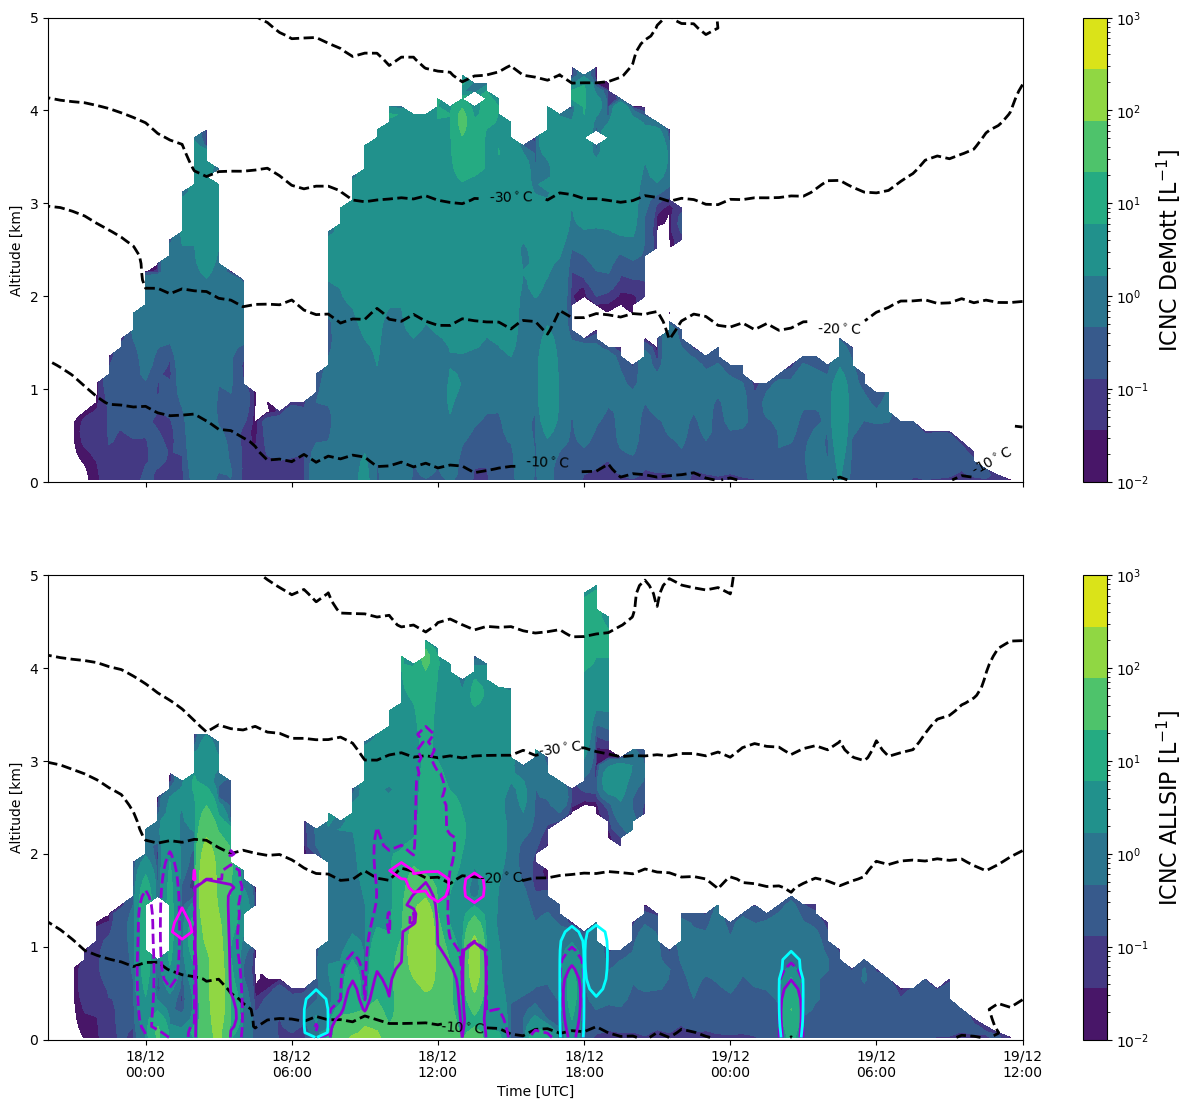

In [8]:
#wrf_time2 = wrf_time_spin_up_end

start_time = datetime.datetime(2021, 12, 17, 18, 0)  # Start time of the timeseries
end_time = datetime.datetime(2021, 12, 19, 14, 0)  # End time of the timeseries
tick_locs = mdates.drange(start_time + datetime.timedelta(hours=6), end_time, datetime.timedelta(hours=6))
tick_labels = [mdates.num2date(t).strftime('%d/%m'+'\n'+ '%H:%M') for t in tick_locs]

#tick_locs = [datetime.datetime(2021, 12, 18, 0, 0),datetime.datetime(2021, 12, 18, 4, 0),datetime.datetime(2021, 12, 18, 8, 0),datetime.datetime(2021, 12, 18, 12, 0),datetime.datetime(2021, 12, 18, 16, 0),datetime.datetime(2021, 12, 18, 20, 0),datetime.datetime(2021, 12, 19, 0, 0),datetime.datetime(2021, 12, 19, 4, 0),datetime.datetime(2021, 12, 19, 8, 0)]

# This is for showing the indices extracted for comparison
fig, axs = plt.subplots(2,1,figsize=(14,14))

plt.subplots_adjust(top=0.85, bottom=0.12, left=0.08, right=0.95, hspace=0.20)


levs = np.logspace(-2, 3, 10)
br = 0.01 #L-1s-1
hm = 0.0001 #L-1s-1
br2 = 0.001 #L-1s-1
sb= 0.0001 #L-1s-1
ds= 0.00001 #L-1s-1


'''
tstmp1 = np.datetime64('2021-12-18T04:20')
i_t1 = np.where(wrf_time2 == tstmp1)[0][0]

tstmp2 = np.datetime64('2021-12-18T07:30')
i_t2 = np.where(wrf_time2 == tstmp2)[0][0]

tstmp2b = np.datetime64('2021-12-18T16:30')
i_t2b = np.where(wrf_time2 == tstmp2b)[0][0]
'''



icnc = axs[0].contourf(wrf_time2, ZZmiddle_1000, to_np(icncDEMOTT.T), levs, norm=colors.LogNorm())
cs = axs[0].contour(wrf_time2, ZZmiddle_1000, tDEMOTT.T, levels=np.arange(-50, 0, 10), colors='black',linewidths=2)

#axs[1].axvline(wrf_time2[i_t1], color='coral', linestyle='dashed',linewidth=2.)
#axs[1].axvline(wrf_time2[i_t2], color='#FFDB58', linestyle='dashed',linewidth=2.)
#axs[1].axvline(wrf_time2[i_t2b], color='#FFDB58', linestyle='dashed',linewidth=2.)


axs[0].clabel(cs, inline=True, fontsize=10, fmt='%d$^\circ$C')
cbar = fig.colorbar(icnc,ax=axs[0])
cbar.ax.set_yscale('log')
cbar.set_label('ICNC DeMott [$\mathrm{L^{-1}}$]', fontsize=16)

axs[0].set_ylabel("Altitude [km]")
axs[0].set_ylim(0,5)
axs[0].set_yticks([0,1,2,3,4,5])
axs[0].set_xticks(tick_locs)
axs[0].set_xticklabels([])
axs[0].set_xlim(wrf_time2[40], wrf_time2[-1])
'''
tstmp1 = np.datetime64('2021-12-18T04:45')
i_t1 = np.where(wrf_time2 == tstmp1)[0][0]

tstmp2 = np.datetime64('2021-12-18T07:30')
i_t2 = np.where(wrf_time2 == tstmp2)[0][0]

tstmp2b = np.datetime64('2021-12-18T17:30')
i_t2b = np.where(wrf_time2 == tstmp2b)[0][0]
'''

icnc = axs[1].contourf(wrf_time2, ZZmiddle_1000, to_np(icncALLSIP.T), levs, norm=colors.LogNorm())
cs = axs[1].contour(wrf_time2, ZZmiddle_1000, tALLSIP.T, levels=np.arange(-50, 0, 10), colors='black',linewidths=2)
br_contour = axs[1].contour(wrf_time2, ZZmiddle_1000, brALLSIP.T, levels=[br], colors='darkviolet',linewidths=2)
hm_contour = axs[1].contour(wrf_time2, ZZmiddle_1000, hmALLSIP.T, levels=[hm], colors='darkcyan',linewidths=2)
br_contour2 = axs[1].contour(wrf_time2, ZZmiddle_1000, brALLSIP.T, levels=[br2], colors='darkviolet',linewidths=2, linestyles='dashed')
sb_contour = axs[1].contour(wrf_time2, ZZmiddle_1000, sbALLSIP.T, levels=[sb], colors='magenta',linewidths=2)
ds_contour = axs[1].contour(wrf_time2, ZZmiddle_1000, dsALLSIP.T, levels=[ds], colors='cyan',linewidths=2)

#axs[2].axvline(wrf_time2[i_t1], color='coral', linestyle='dashed',linewidth=2.)
#axs[2].axvline(wrf_time2[i_t2], color='#FFDB58', linestyle='dashed',linewidth=2.)
#axs[2].axvline(wrf_time2[i_t2b], color='#FFDB58', linestyle='dashed',linewidth=2.)
axs[1].set_ylim(0,5)
axs[1].set_xlim(wrf_time2[0], wrf_time2[-1])
axs[1].set_ylabel("Altitude [km]")
axs[1].set_xlabel("Time [UTC]")
axs[1].set_ylim(0,5)
axs[1].set_yticks([0,1,2,3,4,5])
axs[1].set_xticks(tick_locs)
axs[1].set_xticklabels(tick_labels)
axs[1].set_xlim(wrf_time2[40], wrf_time2[-1])
axs[1].clabel(cs, inline=True, fontsize=10, fmt='%d$^\circ$C')
cbar = fig.colorbar(icnc,ax=axs[1])
cbar.ax.set_yscale('log')
cbar.set_label('ICNC ALLSIP [$\mathrm{L^{-1}}$]', fontsize=16)

plt.show()